Preprocessed 9248 train images.
Preprocessed 973 validation images.
Preprocessed 973 test images.
Shape of processed data: (9248, 128, 128, 3)
289/289 ━━━━━━━━━━━━━━━━━━━━ 89s 300ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 12s 373ms/step
Extracted train features shape: (9248, 4, 4, 2048)
Flattened train features shape: (9248, 32768)
Number of components chosen to retain 80% variance: 34
Reduced train features shape: (9248, 34)
Reduced validation features shape: (973, 34)
Reduced test features shape: (973, 34)


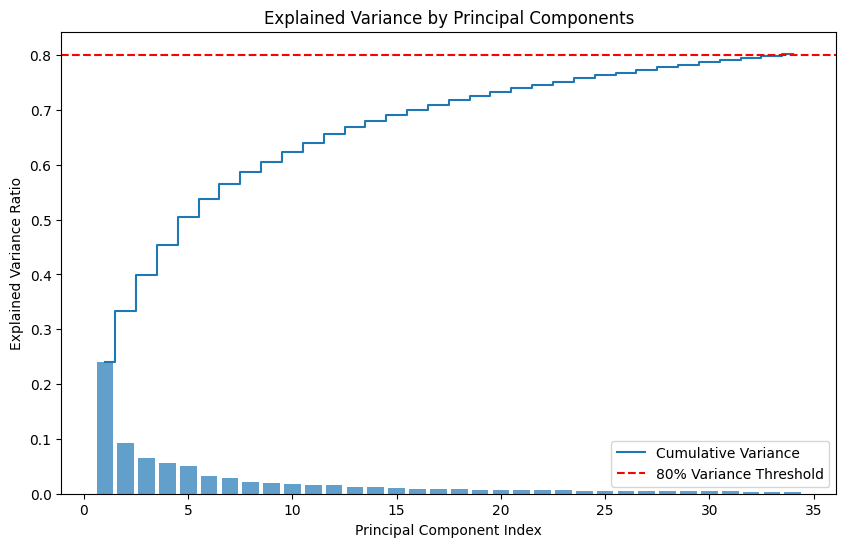

In [1]:
%run preprocessing.ipynb

In [3]:
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import numpy as np
from sklearn.preprocessing import LabelEncoder



# Initialize base models
cat_clf = CatBoostClassifier(
    iterations=3000, learning_rate=0.05, depth=6, l2_leaf_reg=5, border_count=64,
    loss_function='MultiClass', eval_metric='Accuracy', random_seed=42, verbose=100, early_stopping_rounds=100
)
rf_clf = RandomForestClassifier(n_estimators=150, random_state=42)
xgb_clf = XGBClassifier(n_estimators=150, learning_rate=0.05, max_depth=6, random_state=42)

# Train base models
cat_clf.fit(features_train_pca, train_labels_encoded, eval_set=(features_val_pca, val_labels_encoded), verbose=100)
rf_clf.fit(features_train_pca, train_labels_encoded)
xgb_clf.fit(features_train_pca, train_labels_encoded)

# Get predictions from base models (using probabilities)
cat_pred_val = cat_clf.predict_proba(features_val_pca)
rf_pred_val = rf_clf.predict_proba(features_val_pca)
xgb_pred_val = xgb_clf.predict_proba(features_val_pca)

# Stack predictions as new features for the meta-model
stacked_features_val = np.hstack((cat_pred_val, rf_pred_val, xgb_pred_val))

# Initialize and train the meta-model
meta_model = LogisticRegression(random_state=42)
meta_model.fit(stacked_features_val, val_labels_encoded)

# Get predictions from base models for the test set (using probabilities)
cat_pred_test = cat_clf.predict_proba(features_test_pca)
rf_pred_test = rf_clf.predict_proba(features_test_pca)
xgb_pred_test = xgb_clf.predict_proba(features_test_pca)

# Stack predictions as new features for the meta-model
stacked_features_test = np.hstack((cat_pred_test, rf_pred_test, xgb_pred_test))

# Get final predictions from the meta-model
final_predictions = meta_model.predict(stacked_features_test)

# Evaluate the ensemble model
accuracy = accuracy_score(test_labels_encoded, final_predictions)
conf_matrix = confusion_matrix(test_labels_encoded, final_predictions)
class_report = classification_report(test_labels_encoded, final_predictions)

print(f"Ensemble Model Accuracy: {accuracy}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)

0:	learn: 0.5258434	test: 0.5477903	best: 0.5477903 (0)	total: 178ms	remaining: 8m 52s
100:	learn: 0.6822016	test: 0.6947585	best: 0.6947585 (99)	total: 991ms	remaining: 28.5s
200:	learn: 0.7332396	test: 0.7122302	best: 0.7163412 (197)	total: 1.66s	remaining: 23.2s
300:	learn: 0.7728157	test: 0.7153135	best: 0.7194245 (206)	total: 2.31s	remaining: 20.7s
400:	learn: 0.8030926	test: 0.7348407	best: 0.7358684 (395)	total: 3.01s	remaining: 19.5s
500:	learn: 0.8241782	test: 0.7338129	best: 0.7410072 (439)	total: 3.77s	remaining: 18.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7410071942
bestIteration = 439

Shrink model to first 440 iterations.
Ensemble Model Accuracy: 0.7605344295991778
Confusion Matrix:
[[174  17  14  14]
 [ 22 200   8   7]
 [ 12   7 185  58]
 [ 21   4  49 181]]
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.79      0.78       219
           1       0.88      0.84      0.86       237


In [ ]:
# from sklearn.svm import SVC
# from sklearn.preprocessing import LabelEncoder
# from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# # Encode labels as integers
# label_encoder = LabelEncoder()
# y_train_encoded = label_encoder.fit_transform(train_labels)
# y_test_encoded = label_encoder.transform(test_labels)

# # Train the SVM with RBF kernel
# svm_rbf = SVC(kernel='rbf', gamma='scale', random_state=42)  # Changed gamma to 'scale' (recommended default)
# svm_rbf.fit(features_train_pca, y_train_encoded)

# # Predict and evaluate
# y_pred_rbf = svm_rbf.predict(features_test_pca)

# # Calculate accuracy
# accuracy_rbf = accuracy_score(y_test_encoded, y_pred_rbf)
# print('Test Accuracy with RBF Kernel: {:.2f}'.format(accuracy_rbf))

# # Print the confusion matrix
# conf_matrix = confusion_matrix(y_test_encoded, y_pred_rbf)
# print('\nConfusion Matrix:')
# print(conf_matrix)

# # Print the classification report
# class_report = classification_report(y_test_encoded, y_pred_rbf, target_names=label_encoder.classes_)
# print('\nClassification Report:')
# print(class_report)


Test Accuracy with RBF Kernel: 0.79

Confusion Matrix:
[[177  21  14   7]
 [ 11 213   8   5]
 [  7   6 205  44]
 [ 15   7  55 178]]

Classification Report:
              precision    recall  f1-score   support

   buildings       0.84      0.81      0.83       219
      forest       0.86      0.90      0.88       237
    mountain       0.73      0.78      0.75       262
         sea       0.76      0.70      0.73       255

    accuracy                           0.79       973
   macro avg       0.80      0.80      0.80       973
weighted avg       0.79      0.79      0.79       973



In [9]:
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# Initialize CatBoost classifier
cat_clf = CatBoostClassifier(
    iterations=3000,               # Number of boosting rounds
    learning_rate=0.1,             # Lower learning rate for better generalization
    depth=8,                       # Tree depth
    l2_leaf_reg=5,                 # L2 regularization coefficient
    border_count=64,               # Number of splits for numerical features
    loss_function='MultiClass',    # Multiclass classification
    eval_metric='Accuracy',        # Evaluation metric
    random_seed=42,                # For reproducibility
    verbose=100,                   # Output every 100 iterations
    early_stopping_rounds=100      # Early stopping if validation doesn't improve
)

# Train CatBoost
cat_clf.fit(features_train_pca, train_labels_encoded, eval_set=(features_val_pca, val_labels_encoded), use_best_model=True)

# Predict on validation data
y_pred_val = cat_clf.predict(features_val_pca)
accuracy_val = accuracy_score(val_labels_encoded, y_pred_val)
print('Validation Accuracy with CatBoost: {:.2f}'.format(accuracy_val))

# Predict on test data
y_pred_cat = cat_clf.predict(features_test_pca)

# Evaluate performance on test data
accuracy_cat = accuracy_score(test_labels_encoded, y_pred_cat)
print('Test Accuracy with CatBoost: {:.2f}'.format(accuracy_cat))

# Confusion matrix
conf_matrix = confusion_matrix(test_labels_encoded, y_pred_cat)
print('\nConfusion Matrix:')
print(conf_matrix)

# Classification report
class_report = classification_report(test_labels_encoded, y_pred_cat, target_names=label_encoder.classes_)
print('\nClassification Report:')
print(class_report)


0:	learn: 0.5477941	test: 0.5580678	best: 0.5580678 (0)	total: 44.3ms	remaining: 2m 12s
100:	learn: 0.8006055	test: 0.7204522	best: 0.7225077 (99)	total: 1.91s	remaining: 54.8s
200:	learn: 0.8874351	test: 0.7389517	best: 0.7420349 (188)	total: 3.52s	remaining: 49.1s
300:	learn: 0.9391220	test: 0.7451182	best: 0.7502569 (277)	total: 5.13s	remaining: 46s
400:	learn: 0.9703720	test: 0.7502569	best: 0.7553957 (391)	total: 6.73s	remaining: 43.6s
500:	learn: 0.9869161	test: 0.7615622	best: 0.7625899 (499)	total: 8.34s	remaining: 41.6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7625899281
bestIteration = 499

Shrink model to first 500 iterations.
Validation Accuracy with CatBoost: 0.76
Test Accuracy with CatBoost: 0.76

Confusion Matrix:
[[178  17  15   9]
 [ 16 202  13   6]
 [ 17   8 192  45]
 [ 22   4  57 172]]

Classification Report:
              precision    recall  f1-score   support

   buildings       0.76      0.81      0.79       219
      forest       0.87

In [7]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Initialize AdaBoost classifier
# Using a DecisionTreeClassifier as the base estimator
ada_clf = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=3),  # Weak learner with depth-limited decision trees
    n_estimators=150,                                   # Number of boosting rounds
    learning_rate=0.1,                                  # Learning rate for weight updates
    random_state=42                                     # For reproducibility
)

# Train AdaBoost
ada_clf.fit(features_train_pca, train_labels_encoded)

# Predict on test data
y_pred_ada = ada_clf.predict(features_test_pca)

# Evaluate performance
accuracy_ada = accuracy_score(test_labels_encoded, y_pred_ada)
print('Test Accuracy with AdaBoost: {:.2f}'.format(accuracy_ada))

# Confusion matrix
conf_matrix_ada = confusion_matrix(test_labels_encoded, y_pred_ada)
print('\nConfusion Matrix (AdaBoost):')
print(conf_matrix_ada)

# Classification report
class_report_ada = classification_report(test_labels_encoded, y_pred_ada, target_names=label_encoder.classes_)
print('\nClassification Report (AdaBoost):')
print(class_report_ada)


C:\Users\asmun\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Test Accuracy with AdaBoost: 0.73

Confusion Matrix (AdaBoost):
[[169  18  19  13]
 [ 36 183  12   6]
 [ 16   9 191  46]
 [ 23   1  66 165]]

Classification Report (AdaBoost):
              precision    recall  f1-score   support

   buildings       0.69      0.77      0.73       219
      forest       0.87      0.77      0.82       237
    mountain       0.66      0.73      0.69       262
         sea       0.72      0.65      0.68       255

    accuracy                           0.73       973
   macro avg       0.74      0.73      0.73       973
weighted avg       0.73      0.73      0.73       973



In [8]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Initialize XGBoost classifier with selected parameters
xgb_clf = XGBClassifier(
    max_depth=6,                  # Tree depth
    learning_rate=0.1,            # Learning rate
    n_estimators=150,             # Number of boosting rounds
    subsample=0.8,                # Subsampling ratio
    colsample_bytree=0.8,         # Subsampling of columns
    objective='multi:softmax',    # Multiclass classification objective
    eval_metric='mlogloss',       # Evaluation metric
    random_state=42               # For reproducibility
)

# Train XGBoost
xgb_clf.fit(features_train_pca, train_labels_encoded)

# Predict on test data
y_pred_xgb = xgb_clf.predict(features_test_pca)

# Evaluate performance
accuracy_xgb = accuracy_score(test_labels_encoded, y_pred_xgb)
print('Test Accuracy with XGBoost:', accuracy_xgb)

# Confusion matrix
conf_matrix_xgb = confusion_matrix(test_labels_encoded, y_pred_xgb)
print('\nConfusion Matrix (XGBoost):')
print(conf_matrix_xgb)

# Classification report
class_report_xgb = classification_report(test_labels_encoded, y_pred_xgb, target_names=label_encoder.classes_)
print('\nClassification Report (XGBoost):')
print(class_report_xgb)


Test Accuracy with XGBoost: 0.7605344295991778

Confusion Matrix (XGBoost):
[[176  20  12  11]
 [ 21 202   7   7]
 [ 15   5 193  49]
 [ 23   6  57 169]]

Classification Report (XGBoost):
              precision    recall  f1-score   support

   buildings       0.75      0.80      0.78       219
      forest       0.87      0.85      0.86       237
    mountain       0.72      0.74      0.73       262
         sea       0.72      0.66      0.69       255

    accuracy                           0.76       973
   macro avg       0.76      0.76      0.76       973
weighted avg       0.76      0.76      0.76       973

